In [1]:
import numpy as np
import generative_model, generative_model_global
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import copy
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys, os
sys.path.append(os.path.dirname(sys.path[0]))

from discrepancies import datasets, pool2graph, discrepancies_intervals, FairPool_mano, fair_helpers



In [2]:
#import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# Example of Fair classifier (with DNN)

['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
(339, 12) (167, 12) 0.5634218289085545 0.28023598820059


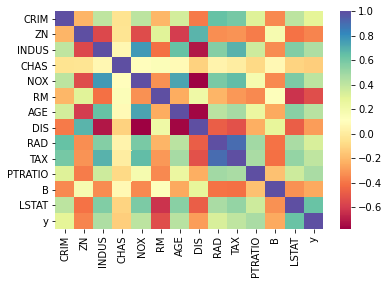

In [11]:


X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset='boston')
sensitive_name = 'ZN'#'B'
X_train2 = X_train.copy()
X_train2['y'] = y_train
sns.heatmap(X_train2.corr(), cmap="Spectral")
Z_train, Z_test = X_train[sensitive_name], X_test[sensitive_name]
Z_train, Z_test  = (Z_train > Z_train.mean()).astype('int'), (Z_test > Z_test.mean()).astype('int')
del X_train[sensitive_name]
del X_test[sensitive_name]

feature_names = [f for f in feature_names if f != sensitive_name]

print(feature_names)
print(X_train.shape, X_test.shape, y_train.mean(), Z_train.mean())

In [12]:
X_train.columns

Index(['CRIM', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

(<AxesSubplot:>, 0.28023598820059)

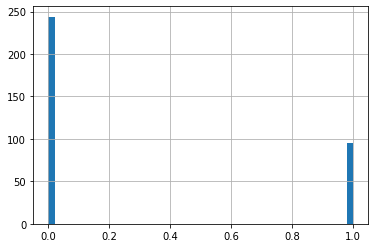

In [13]:
Z_train.hist(bins=50), Z_train.mean()

### Training a fair classifier using clf

Not clear if clf should be trained alone, if clf and adv should be pretrained, or none of the above.

### Comparing a fair and a biased classifier: sandbox

100%|██████████| 500/500 [00:05<00:00, 84.74it/s]


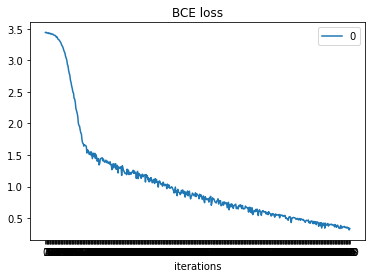

100%|██████████| 3000/3000 [01:50<00:00, 27.15it/s]


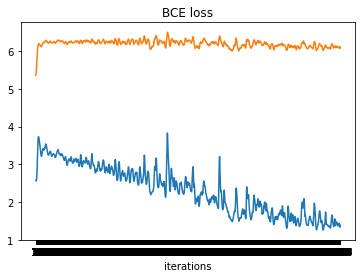

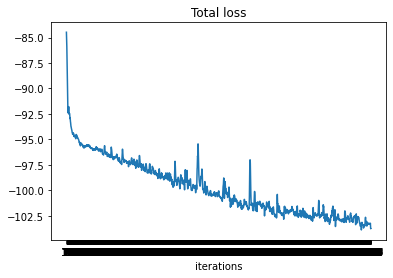

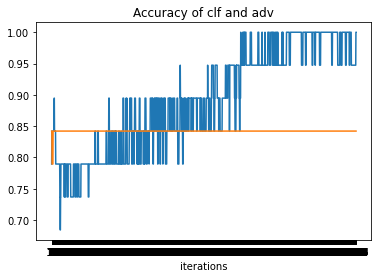

Clf accuracy biased 0.9041916167664671
odds 0.34915439170758317
P-rule biased 34.91543917075832
Clf accuracy fair 0.8802395209580839
odds 0.49944258639910816
P-rule fair 49.944258639910814


In [14]:

N_LAYERS = 5
N_NEURONS = 50
N_EPOCHS = 50

clf_biased = FairPool_mano.Classifier(n_features=X_train.shape[1],
                n_hlayers=N_LAYERS,
                n_hidden=N_NEURONS)
clf_biased.fit(X_train, y_train, n_epochs=500, plot=True) #1000 suffit pour 5 50

clf_dummy = FairPool_mano.Classifier(n_features=X_train.shape[1], n_hlayers=N_LAYERS, n_hidden=N_NEURONS)
clf_fair = FairPool_mano.FairZhang(clf_dummy, lambda_=3.0, adversarial_architecture=[2,5])
clf_fair.pretrain_both(X_train, Z_train, y_train, n_clf_epochs=200, n_adv_epochs=40)
clf_fair.fit(X_train, Z_train, y_train, plot=True, n_epochs=3000)

print("Clf accuracy biased", (clf_biased.predict(X_test) == y_test).mean())
#female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = DNN_pool.get_fairness_metrics(y_train, clf_biased.predict(X_train), Z_train, 1 - Z_train, 0.5)
print('P-rule biased', FairPool_mano.p_rule(clf_biased.predict(X_test), Z_test))

print("Clf accuracy fair", (clf_fair.clf.predict(X_test) == y_test).mean())
#female_tox_rate, nf_tox_rate, female_tp_rate, nf_tp_rate, female_fp_rate, nf_fp_rate, demo_parity, tp_parity, fp_parity, equ_odds = DNN_pool.get_fairness_metrics(y_train, clf_fair.clf.predict(X_train), Z_train, 1 - Z_train, 0.5)
#print('Demographic Parity Fair: %f ; Equalized Odds Fair: %f'%(demo_parity, equ_odds))
print('P-rule fair', FairPool_mano.p_rule(clf_fair.clf.predict(X_test), Z_test))



# Discrepancy analysis with p2g

In [6]:
%%time

#pool1 = FairPool_mano.ZhangPool(lambda_=10.0)
#pool1.fit(X_train, Z_train, y_train, n_epochs=1000, n_epochs_clf=100, n_epochs_adv=10)
#clf_biased, clf_fair = pool1.models
print("Clf accuracy biased", (clf_biased.predict(X_test) == y_test).mean())
print('P-rule biased', FairPool_mano.p_rule(clf_biased.predict(X_test), Z_test))
print("Clf accuracy fair", (clf_fair.predict(X_test) == y_test).mean())
print('P-rule fair', FairPool_mano.p_rule(clf_fair.predict(X_test), Z_test))



p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=20)
p2g.fit(max_epochs=5)



Clf accuracy biased 0.8802395209580839
odds 0.60431654676259
P-rule biased 60.431654676258994
Clf accuracy fair 0.8622754491017964
odds 0.6929496402877698
P-rule fair 69.29496402877699


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


CPU times: user 1.33 s, sys: 13 ms, total: 1.34 s
Wall time: 1.34 s


In [8]:
from sklearn.metrics import confusion_matrix


pd.DataFrame(confusion_matrix(pool1.predict(X_test).iloc[:, 0], pool1.predict(X_test).iloc[:, 1]), columns=['fair 0', 'fair 1'])



NameError: name 'pool1' is not defined

In [ ]:
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
len(intervals)

In [ ]:
global_interval_coord = []
for di in intervals:
    interval_coord = np.array((di.border_features.iloc[0] - di.border_features.iloc[1]).abs())
    global_interval_coord.append(interval_coord)
global_interval_coord = np.array(global_interval_coord)
global_interval_coord = pd.DataFrame(global_interval_coord, columns = X_train.columns)

In [ ]:
sns.set_style()


ax = sns.barplot(data=global_interval_coord, ci=95, palette="Set2")
ax.set_xticklabels(X_train.columns,rotation=30)

plt.tight_layout()

In [ ]:
from sklearn.cluster import KMeans

oneborder = np.array([di.border_features.iloc[0] for di in intervals])
coord_intervals = []
for di in intervals:
    a, b = di.border_features.iloc[0], di.border_features.iloc[1]
    if a[0] > 0:
        interval_coord = a - b
    else:
        interval_coord = a - b
    coord_intervals.append(interval_coord)
coord_intervals = np.array(coord_intervals)
coord_intervals = pd.DataFrame(coord_intervals, columns=X_train.columns)

nodes = p2g.get_nodes_attributes(p2g.get_nodes(discrepancies=True))[0]

clusters_nodes = KMeans(n_clusters=6, n_jobs=-1).fit_predict(nodes)

clusters = clusters_nodes.copy()
data = nodes.copy()


data["cluster"] = clusters
print(data.groupby('cluster').count())

sns.catplot(data=data, col="cluster", kind="box", col_wrap=4)

In [ ]:
from sklearn.manifold import TSNE
try :
    del data["cluster"]
except KeyError:
    pass
tsne = TSNE(perplexity=50, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", hue="cluster", data=tsne)
plt.title("t-SNE vizualisation of discrepancy nodes")
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

### Observations 
#### Boston
- On a des clusters différents, des zones différentes de l'espace où le débiaisage se fait.
    - est-ce vraiment du au débiaisage? ou est-ce une zone d'incertitude que j'aurais eu sur des modèles différents quelconques? 
        - Est-ce une vraie question ?
        - En attendant: en comparant par rapport à l'autre notebook (mis dans le papier): certains clusters semblent semblables, d'autres non.
    - ce sont des zones où débiaiser à fait changer la prédiction
        - sans doute des variables corrélées donc?
        - ou bien, comme disait Vincent, celles qui dépendant causalement
- Compliqué de réellement observer ce qu'il faut, car on est limité par les datasets. Variables catégorielles vs. continues notamment
    
- https://arxiv.org/pdf/2006.08204.pdf Robust VAE for tabular data: gère les données catégorielles


# Next steps

- Use AIF360.... 
- 


In [ ]:

generator = {'model': generative_model.DiscGen(n_touchpoints=len(model_pool),
                            n_features=X_train.shape[1],
                            n_hlayers=5,
                            n_hidden=50,
                            p_dropout=0.0)}
generator['optimizer'] = optim.Adam(generator['model'].parameters())
generator['loss_parameters'] = {
                    'k_align': 10.0,
                    'k_disc': 10.0}

N_EPOCHS_G = 40
generative_model.train_generator(generator, model_pool, train_loader, N_EPOCHS_G, plot=True)


In [ ]:
#X_test_disc
y_test_discr = []
a = 0
for x, _ in test_loader:
    pred = np.array([model['model'](x).detach().numpy() for model in model_pool]).reshape(2, -1)
    pred = (pred >= 0.5).astype('int').mean(axis=0)
    y_disc = ((pred < 1.0) * (pred > 0.0)).astype('int')
    y_test_discr.extend(y_disc)
    a += _.sum()
y_test_discr = torch.Tensor(y_test_discr).reshape(-1, 1)

discr_boys = X_test[torch.where(y_test_discr == 1)[0], :]
their_friends = generator['model'](torch.Tensor(discr_boys))

# comment analyser ça ? Est ce que le local est vriament ce qu'on veut ici ? 
# On sait quels TP sont pour quel modèle.

## Generative global

In [ ]:
########################
# Dans notebook
generator = {'model': generative_model_global.GlobalDiscGen(#n_touchpoints=len(model_pool),
                            n_features=X_train.shape[1],
                            n_hlayers=5,
                            n_hidden=50,
                            p_dropout=0.0)}
generator['optimizer'] = optim.Adam(generator['model'].parameters())
generator['loss_parameters'] = {
                    'k_align': 10.0,
                    'k_disc': 10.0}

N_EPOCHS_G = 40
generative_model_global.train_generator(generator, model_pool, train_loader, N_EPOCHS_G, plot=True)

In [ ]:
#evaluation

## sampling kde
## labellisation avec la pool; 1 si disc, 0 sinon
## on vérifie qu'on génère uniquement dans la zone disc.